In [4]:
from tms_risk.utils.data import Subject, get_all_subject_ids, get_tms_conditions, get_subjects, get_all_behavior
import numpy as np
import pandas as pd
from pathlib import Path

bids_folder = Path('/data/ds-tmsrisk')


In [5]:
from argparse import ArgumentParser
from tms_risk.utils.data import Subject, get_empirical_prior_n
from pathlib import Path
import pandas as pd
import numpy as np
from nilearn.input_data import NiftiMasker
from tms_risk.encoding_model.fit_regression_nprf import get_model
from braincoder.optimize import ResidualFitter
from braincoder.utils import get_rsq
from braincoder.utils.math import get_expected_value

In [6]:
roi = 'NPCr2cm-cluster'
subject = 2
bids_folder = '/data/ds-tmsrisk'

In [22]:
sub = Subject(subject)

bids_folder = Path(bids_folder)

target_dir = bids_folder / 'derivatives' / 'expected_uncertainty' / f'sub-{subject:02d}' / 'func'
target_dir.mkdir(parents=True, exist_ok=True)

pars = sub.get_prf_parameters2(model_label=1, roi=roi)

paradigm = sub.get_paradigm()
paradigm = paradigm.reset_index('session')[['log(n1)', 'session']].rename(columns={'log(n1)': 'x'}).astype(np.float32).droplevel(1)

# Get prf parameters
print('Getting prf parameters...')

model = get_model(1, paradigm)

raw_pars2 = model._base_transform_parameters_backward(pars[['mu', 'sd', 'amplitude', 'baseline']].xs(2, level=1, axis=1))
raw_pars3 = model._base_transform_parameters_backward(pars[['mu', 'sd', 'amplitude', 'baseline']].xs(3, level=1, axis=1))

raw_pars = np.stack([raw_pars2[:, 0], raw_pars2[:,1], raw_pars2[:, 2], raw_pars3[:, 2], raw_pars2[:, 3]], axis=1)
raw_pars = pd.DataFrame(raw_pars, columns=model.parameter_labels)

cvr2 = pars[('cvr2', None)]
cvr2_mask = (cvr2 > 0.0) & (np.isfinite(raw_pars).all(axis=1))

# Get mask
mask = bids_folder / 'derivatives' / 'fmriprep' / f'sub-{subject}' / f'ses-1' / 'func' / f'sub-{subject}_ses-1_task-task_run-1_space-T1w_desc-brain_mask.nii.gz'
mask = sub.get_volume_mask(session=1, roi=roi, epi_space=True)
masker = NiftiMasker(mask_img=mask)

# Get single-trial data
data2 = bids_folder / 'derivatives' / 'glm_stim1.denoise.smoothed' / f'sub-{subject:02d}' / f'ses-2' / 'func' / f'sub-{subject:02d}_ses-2_task-task_space-T1w_desc-stims1_pe.nii.gz'
data3 = bids_folder / 'derivatives' / 'glm_stim1.denoise.smoothed' / f'sub-{subject:02d}' / f'ses-3' / 'func' / f'sub-{subject:02d}_ses-3_task-task_space-T1w_desc-stims1_pe.nii.gz'

data = pd.DataFrame(np.vstack([masker.fit_transform(data2), masker.fit_transform(data3)]), index=paradigm.index)
data = pd.DataFrame(data, index=paradigm.index).astype(np.float32)

print('Masking data.')
data = data.loc[:, cvr2_mask]
raw_pars = raw_pars.loc[cvr2_mask, :]


stimulus_range = np.linspace(paradigm['x'].min(), paradigm['x'].max(), 100).astype(np.float32)
model.init_pseudoWWT(stimulus_range, raw_pars)

pred = model.predict(paradigm, raw_pars)
r2 = get_rsq(data, pred)
print(r2)
assert(r2[cvr2_mask].min() > 0.0), "Some voxels have negative R², cannot proceed"



resid_fitter = ResidualFitter(model, data, paradigm, raw_pars)
omega, dof = resid_fitter.fit(method='t', spherical=True)


print('Simulating data...')
x = np.log(np.arange(5, 28*4))
sessions = [2.0, 3.0]
fake_paradigm = pd.DataFrame({
    'x': np.tile(x, len(sessions)),
    'session': np.repeat(sessions, len(x))
}).astype(np.float32)

model = get_model(1, fake_paradigm)
simulated_data = model.simulate(paradigm=fake_paradigm, parameters=raw_pars, noise=omega, dof=dof, n_repeats=50)



Getting prf parameters...
Masking data.


1      0.060453
7      0.064811
70     0.073752
71     0.034465
72     0.059173
77     0.057643
95     0.054564
96     0.101528
97     0.160928
98     0.093281
102    0.062657
106    0.084116
111    0.089826
113    0.164605
118    0.112543
119    0.172263
120    0.181815
122    0.224421
135    0.095922
145    0.155435
154    0.095267
158    0.307731
161    0.064712
176    0.079749
179    0.091429
185    0.074712
188    0.037155
192    0.050132
Name: r2, dtype: float32
init_tau: 0.3387908935546875, 1.334712028503418


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulating data...
(50, 214, 28)


2025-12-01 11:32:06.762851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-01 11:32:06.801349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-01 11:32:06.802842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-01 11:32:06.803465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-01 11:32:06.806427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-01 11:32:06.807075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

In [23]:
# Calculating pd
print('Calculating pdf...')
pdf = model.get_stimulus_pdf(simulated_data, stimulus_range=fake_paradigm, parameters=raw_pars, omega=omega, dof=dof, normalize=True)
pdf = pdf.unstack('repeat')
pdf.index = pd.MultiIndex.from_frame(fake_paradigm)
# print(pdf)

pdf = pdf.apply(lambda d: d.xs(d.name[1], level='session'), axis=1).stack('repeat')


Calculating pdf...
Note that non-stimulus dimensions (e.g., the regressors) are part of the likelihood calculation!


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89417/362121380.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdf = pdf.apply(lambda d: d.xs(d.name[1], level='session'), axis=1).stack('repeat')


In [ ]:
pdf.columns = np.round(np.exp(pdf.columns.astype(np.float32)))

# # x-level of index should take the exponential
pdf = pdf.reset_index()
print(pdf)
pdf['x'] = np.exp(pdf['x'])
pdf = pdf.set_index(['x', 'session', 'repeat'])
print(pdf)


# # decode_pars.to_csv(target_dir / f'sub-{subject:02d}_roi-{roi}_desc-expected_error.tsv', sep='\t')

x             x  session  repeat           5.0           6.0           7.0  \
0      1.609438      2.0       0  1.000000e+00  6.674823e-01  3.175138e-01   
1      1.609438      2.0       1  5.737109e-01  6.412463e-01  6.549472e-01   
2      1.609438      2.0       2  1.000000e+00  8.382137e-01  5.669848e-01   
3      1.609438      2.0       3  2.427355e-01  2.789172e-01  2.978440e-01   
4      1.609438      2.0       4  6.520685e-01  9.665269e-01  1.000000e+00   
...         ...      ...     ...           ...           ...           ...   
10695  4.709530      3.0      45  2.613746e-01  2.581010e-01  2.527181e-01   
10696  4.709530      3.0      46  1.355308e-02  1.954754e-02  2.480721e-02   
10697  4.709530      3.0      47  4.505408e-06  9.109788e-06  1.512082e-05   
10698  4.709530      3.0      48  4.122742e-07  8.379905e-07  1.503235e-06   
10699  4.709530      3.0      49  1.700672e-07  2.911517e-07  4.255864e-07   

x               8.0       9.0      10.0      11.0  ...     102.

In [28]:
prior = get_empirical_prior_n(bids_folder)
prior.index = prior.index.astype(np.float32).set_names('x')


In [30]:
prior.T

x
7.0      0.102405
8.0      0.003836
9.0      0.005754
10.0     0.108638
11.0     0.008630
           ...   
107.0    0.000479
108.0    0.000000
109.0    0.000000
110.0    0.000000
111.0    0.000479
Name: p, Length: 105, dtype: float64

In [32]:
pdf = (pdf * prior.T).fillna(0.0)

In [33]:
pars = pd.DataFrame(index=pdf.index)
pars['E'] = get_expected_value(pdf, normalize=True)
pars['error'] = pars['E'] - pars.index.get_level_values('x')
pars['abs(error)'] = pars['error'].abs()

mean_E = pars.groupby(['session', 'x'])['E'].mean().to_frame("mean_E")
mean_error = pars.groupby(['session', 'x'])['error'].mean().to_frame("mean_error")
var_E = pars.groupby(['session', 'x'])['E'].var().to_frame("var_E")
abs_error = pars.groupby(['session', 'x'])['abs(error)'].mean().to_frame("mean_abs_error")

decode_pars = mean_E.join(mean_error).join(var_E).join(abs_error)


<Axes: xlabel='x', ylabel='mean_E'>

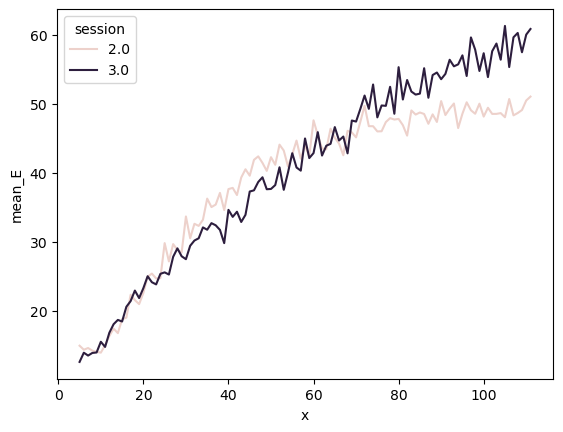

In [36]:
import seaborn as sns
sns.lineplot(x='x', y='mean_E', data=mean_E.reset_index(), hue='session')

<Axes: xlabel='x', ylabel='mean_abs_error'>

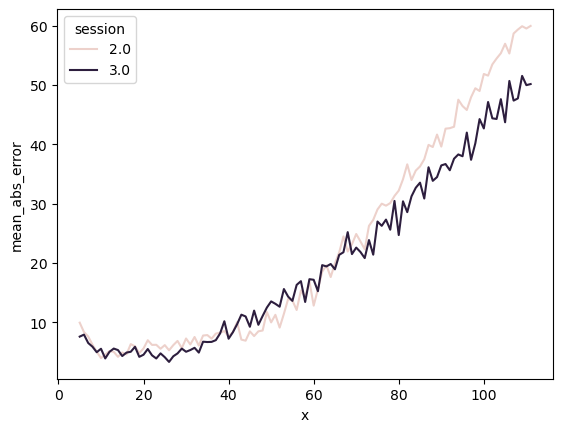

In [37]:
sns.lineplot(x='x', y='mean_abs_error', data=decode_pars.reset_index(), hue='session')

<Axes: xlabel='x', ylabel='x'>

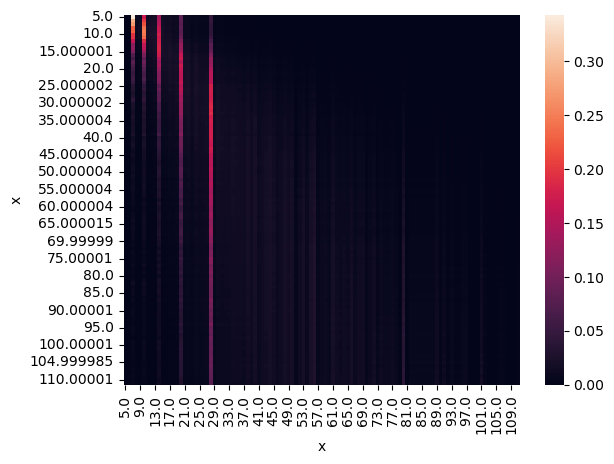

In [38]:
import seaborn as sns
sns.heatmap(pdf.groupby('x').mean())

In [39]:
pdf.div(pdf.sum(1), ).groupby('x').mean()

x          5.000000                                                 ...  \
session           2.0                                               ...   
repeat             0    1    2    3    4    5    6    7    8    9   ...   
x                                                                   ...   
5.000000          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
6.000000          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
7.000000          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
8.000000          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
9.000000          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
106.999985        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
108.000008        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
109.000023        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
110.000008        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
111.000015        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

x          111.000015                                      
session           3.0                                      
repeat             40  41  42  43  44  45  46  47  48  49  
x                                                          
5.000000          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
6.000000          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
7.000000          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
8.000000          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
9.000000          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...               ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  
106.999985        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
108.000008        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
109.000023        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
110.000008        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
111.000015        NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[107 rows x 10700 columns]

In [40]:
sns.heatmap((pdf.div(pdf.sum(1), ).groupby('x').mean())

SyntaxError: incomplete input (2948063853.py, line 1)

In [92]:
pdf.sum(1)

repeat  stimulus
0       0           1.224795e-11
        1           1.117103e-12
        2           6.750198e-10
        3           9.754466e-01
        4           2.664177e-07
                        ...     
499     209         7.731155e-08
        210         2.187391e-15
        211         4.494234e-04
        212         9.087684e-03
        213         1.335496e-05
Length: 107000, dtype: float32

<Axes: xlabel='x', ylabel='var_E'>

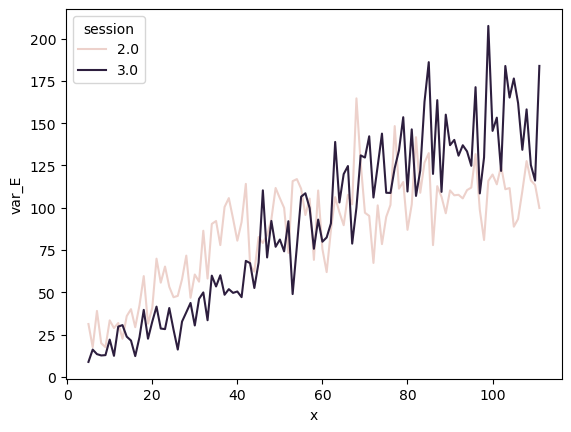

In [41]:
sns.lineplot(data=decode_pars.reset_index(), x='x', y='var_E', hue='session')

In [80]:
pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

<Axes: xlabel='x', ylabel='x-session-repeat'>

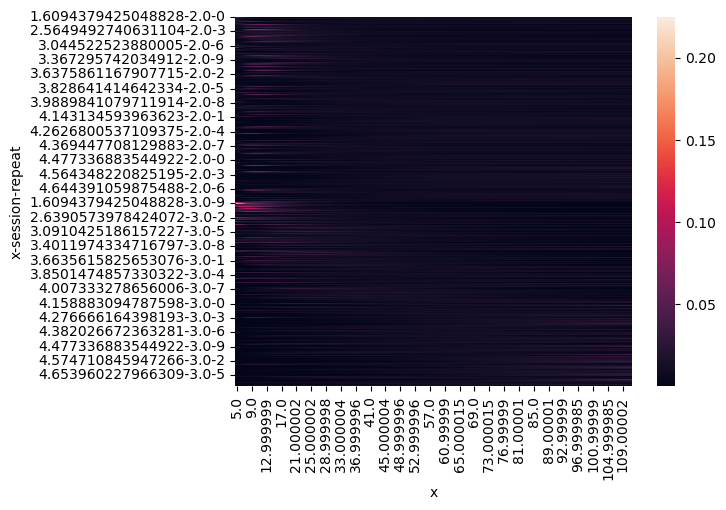

In [81]:
sns.heatmap(pdf)

In [144]:
subject = 3
roi = 'NPCr2cm-cluster'

sub = Subject(subject)

pars = sub.get_prf_parameters2(model_label=1, roi=roi)

paradigm = sub.get_paradigm()
paradigm = paradigm.reset_index('session')[['log(n1)', 'session']].rename(columns={'log(n1)': 'x'}).astype(np.float32).droplevel(1)
from tms_risk.encoding_model.fit_regression_nprf import get_model

model = get_model(1, paradigm)


In [ ]:
raw_pars2 = model._base_transform_parameters_backward(pars[['mu', 'sd', 'amplitude', 'baseline']].xs(2, level=1, axis=1))
raw_pars3 = model._base_transform_parameters_backward(pars[['mu', 'sd', 'amplitude', 'baseline']].xs(3, level=1, axis=1))

raw_pars = np.stack([raw_pars2[:, 0], raw_pars2[:,1], raw_pars2[:, 2], raw_pars3[:, 2], raw_pars2[:, 3]], axis=1)
raw_pars = pd.DataFrame(raw_pars, columns=model.parameter_labels)


In [149]:
cvr2 = pars[('cvr2', None)]

In [181]:
cvr2_mask = (cvr2 > 0.0) & (np.isfinite(raw_pars).all(axis=1))

In [182]:
from nilearn.maskers import NiftiMasker
mask = bids_folder / 'derivatives' / 'fmriprep' / f'sub-{subject}' / f'ses-1' / 'func' / f'sub-{subject}_ses-1_task-task_run-1_space-T1w_desc-brain_mask.nii.gz'
mask = sub.get_volume_mask(session=1, roi=roi, epi_space=True)
masker = NiftiMasker(mask_img=mask)

data2 = bids_folder / 'derivatives' / 'glm_stim1.denoise.smoothed' / f'sub-{subject:02d}' / f'ses-2' / 'func' / f'sub-{subject:02d}_ses-2_task-task_space-T1w_desc-stims1_pe.nii.gz'
data3 = bids_folder / 'derivatives' / 'glm_stim1.denoise.smoothed' / f'sub-{subject:02d}' / f'ses-3' / 'func' / f'sub-{subject:02d}_ses-3_task-task_space-T1w_desc-stims1_pe.nii.gz'

data = pd.DataFrame(np.vstack([masker.fit_transform(data2), masker.fit_transform(data3)]), index=paradigm.index)
data = pd.DataFrame(data, index=paradigm.index).astype(np.float32)

In [183]:
data = data.loc[:, cvr2_mask]
raw_pars = raw_pars.loc[cvr2_mask, :]

In [184]:
from braincoder.optimize import ResidualFitter

In [185]:
stimulus_range = np.linspace(paradigm['x'].min(), paradigm['x'].max(), 100).astype(np.float32)
model.init_pseudoWWT(stimulus_range, raw_pars)

<tf.Tensor: shape=(48, 48), dtype=float32, numpy=
array([[  2.2261512 ,  -2.8235326 ,  -5.264608  , ...,  -0.81104213,
          3.7328415 ,   2.5384076 ],
       [ -2.8235326 ,   9.881443  ,  17.918848  , ...,   2.0221133 ,
         -8.875969  ,  -5.444313  ],
       [ -5.264608  ,  17.918848  ,  32.62332   , ...,   4.4121885 ,
        -16.710344  , -10.540058  ],
       ...,
       [ -0.81104213,   2.0221133 ,   4.4121885 , ...,   5.5918508 ,
         -5.892083  ,  -5.6729293 ],
       [  3.7328415 ,  -8.875969  , -16.710344  , ...,  -5.892083  ,
         12.376199  ,   9.274343  ],
       [  2.5384076 ,  -5.444313  , -10.540058  , ...,  -5.6729293 ,
          9.274343  ,   7.811977  ]], dtype=float32)>

In [186]:
raw_pars

parameter mu_unbounded sd_unbounded amplitude_unbounded                  \
regressor    Intercept    Intercept     C(session)[2.0] C(session)[3.0]   
20            2.792203     0.787970            0.209085        0.376536   
24           -3.483099     3.733171            1.500929       -0.368838   
25           -3.533600     4.055847            2.314386       -0.386565   
26           -2.602887     3.658767            1.258027       -0.399148   
28           -2.602515     3.069688            1.866970       -0.360696   
29           -0.434167     1.115003            3.018833        4.426392   
37           -4.609498     4.850621            1.707116       -0.246471   
38           -4.037465     4.325656            2.719918       -0.263973   
39            1.401545     1.541407            0.695836       -0.087517   
43           -3.056271     4.353124            1.902317       -0.250415   
44           -1.560000     3.482129            1.259779        0.286200   
45            2.460710     2.632409            0.650146        0.438190   
54           -3.984617     4.996351            1.698028       -0.246035   
55           -3.589497     4.857604            1.735628       -0.245995   
57            2.322220     2.655102            1.009953        0.787570   
63           -3.461651     4.117075            3.192663       -0.255597   
64           -3.040488     3.404862            1.646847       -0.393574   
69           -1.050515     3.194741            1.221365       -0.167471   
73            1.117021     1.872772            0.395243       -0.267756   
85            2.559624     1.363275           -0.066294        0.531677   
86            0.450867     5.702312            0.469554       -0.238204   
91           -2.983065     3.236046            2.841143       -0.250918   
92            1.992048     1.401740            0.381287        0.095957   
96           -0.973132     2.688718            1.002516       -0.389418   
101           1.600168     1.707679            0.746456       -0.273792   
104           0.513367     2.230834            0.576972       -0.151993   
109          -2.222901     4.295692            0.942625       -0.393453   
110           0.583610     0.989337            0.142742        0.703757   
121          -2.711483     4.392378           -0.352742        1.107786   
128           2.047547     1.537415            0.436636       -0.224782   
129           2.787968     2.939584            1.556809        1.359017   
142           2.113135     0.108007            0.641201        1.591997   
145           4.116334     0.081024            0.481687        0.310505   
148          -6.558332     4.426886           -0.357930        2.878330   
154           2.114111     0.118080            0.139503        1.592738   
156           1.152357     2.411365           -0.399699        0.759126   
159           2.170123     3.293311            1.300429        1.116641   
167           2.942145     2.742851            2.025447        1.769773   
191           3.299604     0.733551            0.340610       -0.262371   
193          -5.972031     3.986431           -0.318890        3.883452   
195           4.178838     0.069073            0.587938        0.173197   
199          -0.998374     4.248260            1.031844       -0.331802   
203          -0.771980     4.237124            0.957227       -0.328053   
205          -0.606242     4.156986            0.856597       -0.236861   
206           1.138180     3.847682            0.279530       -0.388624   
230           3.278130     2.134604            1.379995        1.158163   
272          -3.982565     4.032535           -0.374453        1.855985   
273          -2.539299     3.503303           -0.250487        1.084821   

parameter baseline_unbounded  
regressor          Intercept  
20                 -0.243173  
24                 -0.087522  
25                 -0.185334  
26                 -0.100209  
28                 -0.137278  
29                  0.071089  
3

In [187]:
resid_fitter = ResidualFitter(model, data, paradigm, raw_pars)

In [188]:
pred = model.predict(paradigm, raw_pars)

get_rsq(data, pred)

20     0.065963
24     0.256009
25     0.354332
26     0.288402
28     0.223359
29     0.053022
37     0.314309
38     0.397009
39     0.213545
43     0.443506
44     0.274837
45     0.072086
54     0.343602
55     0.439312
57     0.112694
63     0.494718
64     0.251376
69     0.356367
73     0.107206
85     0.340639
86     0.259082
91     0.276632
92     0.076387
96     0.195758
101    0.303148
104    0.170954
109    0.329734
110    0.041185
121    0.350261
128    0.132887
129    0.059313
142    0.084406
145    0.022282
148    0.124537
154    0.107330
156    0.398462
159    0.076287
167    0.059951
191    0.063988
193    0.148654
195    0.021347
199    0.293441
203    0.304843
205    0.296605
206    0.084481
230    0.040891
272    0.094775
273    0.076373
Name: r2, dtype: float32

In [189]:
resid = data - pred

In [190]:
omega, dof = resid_fitter.fit(method='t', spherical=True)

init_tau: 0.3147537410259247, 0.701869010925293


  0%|          | 0/1000 [00:00<?, ?it/s]

In [209]:
from braincoder.utils.math import get_expected_value, get_sd_posterior

In [220]:
x = np.log(np.linspace(5, 28*4))
sessions = [2.0, 3.0]

fake_paradigm = pd.DataFrame({
    'x': np.tile(x, len(sessions)),
    'session': np.repeat(sessions, len(x))
}).astype(np.float32)


model = get_model(1, fake_paradigm)
simulated_data = model.simulate(paradigm=fake_paradigm, parameters=raw_pars, noise=omega, dof=dof, n_repeats=5)


2025-11-26 14:52:30.518756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-11-26 14:52:30.629520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-11-26 14:52:30.645685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-11-26 14:52:30.647857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-11-26 14:52:30.661660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-11-26 14:52:30.669204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

(5, 100, 48)


In [221]:
fake_paradigm

,x,session
0,1.609438,2.0
1,1.971811,2.0
2,2.237230,2.0
3,2.446774,2.0
4,2.619925,2.0
...,...,...
95,4.637301,3.0
96,4.658227,3.0
97,4.678724,3.0
98,4.698809,3.0


In [224]:
fake_paradigm.values.ndim

2

In [ ]:
def get_stimulus_pdf(self, data, stimulus_range, parameters=None, weights=None, omega=None, dof=None, normalize=True,
                        include_multidimensional_stimulus_index=False):

    if hasattr(data, 'values'):
        time_index = data.index
        data = data.values
    else:
        time_index = pd.Index(np.arange(len(data)), name='frame')

    parameters = self._get_parameters(parameters)

    if hasattr(stimulus_range, 'values'):
        stimulus_range = stimulus_range.values

    if hasattr(parameters, 'values'):
        parameters = parameters.values

    if omega is None:
        omega = self.omega

    weights, weights_ = self._get_weights(weights)

    # stimuli: n_batches x n_timepoints x n_stimulus_features
    # data: n_batches x n_timepoints x n_units
    # parameters: n_batches x n_subpops x n_parmeters
    # weights: n_batches x n_subpops x n_units
    # omega: n_units x n_units

    stimulus_range = self.stimulus._clean_paradigm(stimulus_range)

    print(stimulus_range.shape)

    if stimulus_range.ndim == 1:
        stimulus_range = stimulus_range[:, np.newaxis, np.newaxis]
    elif stimulus_range.ndim == 2:
        stimulus_range = stimulus_range[:, np.newaxis, :]
    else:
        raise Exception('Stimulus range needs to be either 1D or 2D')

    print(stimulus_range.shape)
    print(data.shape)

    # n_batches * n_timepoints x n_stimulus_features
    ll = self._likelihood(stimulus_range,
                            data[np.newaxis, :, :],
                            parameters[np.newaxis, :, :] if parameters is not None else None,
                            weights_,
                            omega,
                            dof,
                            logp=True,
                            normalize=False).numpy()

    
    if stimulus_range.shape[-1] == 1:
        ll = pd.DataFrame(ll.T, index=time_index, columns=pd.Index(
            stimulus_range[:, 0, 0], name='stimulus'))
    else:
        if include_multidimensional_stimulus_index:
            index = pd.MultiIndex.from_frame(pd.DataFrame(stimulus_range[:, 0, :],
                                            columns=self.stimulus.dimension_labels))
        else:
            index = None

        ll = pd.DataFrame(ll.T, index=time_index, columns=index)

    # Normalize, working from log likelihoods (otherwise we get numerical issues)
    ll = np.exp(ll.apply(lambda d: d-d.max(), 1))
    # ll = ll.apply(lambda d: d/d.sum(), axis=1)

    # ll = np.exp(ll)

    if normalize:
        ll /= np.trapz(ll, ll.columns)[:, np.newaxis]

    return ll


In [240]:
model._likelihood?

Signature:     
model._likelihood(
    stimuli,
    data,
    parameters,
    weights,
    omega_chol,
    dof,
    logp=False,
    normalize=False,
)
Call signature: model._likelihood(*args, **kwds)
Type:           Function
String form:    <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x377113cd0>
File:           ~/mambaforge/envs/tms_risk/lib/python3.11/site-packages/braincoder/models.py
Init docstring:
Initializes a `Function`.

Args:
  python_function: the function to be wrapped.
  name: the name given to it.
  input_signature: See the documentation for `tf.function`.
  autograph: See the documentation for `tf.function`.
  jit_compile: See the documentation for `tf.function`.
  reduce_retracing: See the documentation for `tf.function`.
  experimental_implements: See the documentation for `tf.function`.
  experimental_autograph_options: See the documentation for `tf.function`.
  experimental_attributes: See the documentation for `tf.function`.

In [238]:
get_stimulus_pdf(model, simulated_data, stimulus_range=fake_paradigm, parameters=raw_pars, omega=omega, dof=dof, normalize=False)

(100, 2)
(100, 1, 2)
(500, 48)


ValueError: in user code:

    File "/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/braincoder/models.py", line 374, in _likelihood  *
        return self._likelihood_timeseries(data, prediction, omega_chol, dof, logp, normalize)
    File "/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/braincoder/models.py", line 381, in _likelihood_timeseries  *
        residuals = data - prediction

    ValueError: Dimensions must be equal, but are 500 and 100 for '{{node sub}} = Sub[T=DT_FLOAT](data, prediction)' with input shapes: [1,500,48], [1,100,48].


In [ ]:
pdf =  model.get_stimulus_pdf(simulated_data, parameters=raw_pars, omega=omega, dof=dof, stimulus_range=fake_paradigm, normalize=False)

KeyError: "None of [MultiIndex([(       'mu_unbounded',       'Intercept'),\n            (       'sd_unbounded',       'Intercept'),\n            ('amplitude_unbounded', 'C(session)[2.0]'),\n            ('amplitude_unbounded', 'C(session)[3.0]'),\n            ( 'baseline_unbounded',       'Intercept')],\n           names=['parameter', 'regressor'])] are in the [columns]"

In [218]:
pdf

,0
stimulus,
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
95,1.0
96,1.0
97,1.0


In [201]:
model.simulate?

Signature:
model.simulate(
    paradigm=None,
    parameters=None,
    weights=None,
    noise=1.0,
    dof=None,
    n_repeats=1,
)
Docstring: <no docstring>
File:      ~/mambaforge/envs/tms_risk/lib/python3.11/site-packages/braincoder/models.py
Type:      method

In [200]:
raw_pars

parameter mu_unbounded sd_unbounded amplitude_unbounded                  \
regressor    Intercept    Intercept     C(session)[2.0] C(session)[3.0]   
20            2.792203     0.787970            0.209085        0.376536   
24           -3.483099     3.733171            1.500929       -0.368838   
25           -3.533600     4.055847            2.314386       -0.386565   
26           -2.602887     3.658767            1.258027       -0.399148   
28           -2.602515     3.069688            1.866970       -0.360696   
29           -0.434167     1.115003            3.018833        4.426392   
37           -4.609498     4.850621            1.707116       -0.246471   
38           -4.037465     4.325656            2.719918       -0.263973   
39            1.401545     1.541407            0.695836       -0.087517   
43           -3.056271     4.353124            1.902317       -0.250415   
44           -1.560000     3.482129            1.259779        0.286200   
45            2.460710     2.632409            0.650146        0.438190   
54           -3.984617     4.996351            1.698028       -0.246035   
55           -3.589497     4.857604            1.735628       -0.245995   
57            2.322220     2.655102            1.009953        0.787570   
63           -3.461651     4.117075            3.192663       -0.255597   
64           -3.040488     3.404862            1.646847       -0.393574   
69           -1.050515     3.194741            1.221365       -0.167471   
73            1.117021     1.872772            0.395243       -0.267756   
85            2.559624     1.363275           -0.066294        0.531677   
86            0.450867     5.702312            0.469554       -0.238204   
91           -2.983065     3.236046            2.841143       -0.250918   
92            1.992048     1.401740            0.381287        0.095957   
96           -0.973132     2.688718            1.002516       -0.389418   
101           1.600168     1.707679            0.746456       -0.273792   
104           0.513367     2.230834            0.576972       -0.151993   
109          -2.222901     4.295692            0.942625       -0.393453   
110           0.583610     0.989337            0.142742        0.703757   
121          -2.711483     4.392378           -0.352742        1.107786   
128           2.047547     1.537415            0.436636       -0.224782   
129           2.787968     2.939584            1.556809        1.359017   
142           2.113135     0.108007            0.641201        1.591997   
145           4.116334     0.081024            0.481687        0.310505   
148          -6.558332     4.426886           -0.357930        2.878330   
154           2.114111     0.118080            0.139503        1.592738   
156           1.152357     2.411365           -0.399699        0.759126   
159           2.170123     3.293311            1.300429        1.116641   
167           2.942145     2.742851            2.025447        1.769773   
191           3.299604     0.733551            0.340610       -0.262371   
193          -5.972031     3.986431           -0.318890        3.883452   
195           4.178838     0.069073            0.587938        0.173197   
199          -0.998374     4.248260            1.031844       -0.331802   
203          -0.771980     4.237124            0.957227       -0.328053   
205          -0.606242     4.156986            0.856597       -0.236861   
206           1.138180     3.847682            0.279530       -0.388624   
230           3.278130     2.134604            1.379995        1.158163   
272          -3.982565     4.032535           -0.374453        1.855985   
273          -2.539299     3.503303           -0.250487        1.084821   

parameter baseline_unbounded  
regressor          Intercept  
20                 -0.243173  
24                 -0.087522  
25                 -0.185334  
26                 -0.100209  
28                 -0.137278  
29                  0.071089  
3